![Pipeline](https://i.ibb.co/gVR1fb6/coffee-diseases-classifier-drawio.png "Pipeline")

In [10]:
!pip install tensorflow
!pip install matplotlib

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
project_path = '/content/drive/MyDrive/coffee-disease-classifier'

import os
import logging
from PIL import Image
import tensorflow as tf
import warnings

# Import important libraries and modules
# https://stackoverflow.com/questions/55178230/what-is-the-difference-between-keras-and-tf-keras
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def is_image_valid(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {file_path} - {e}")
        return False

def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_image_valid(file_path):
                os.remove(file_path)
                print(f"Removed corrupted image: {file_path}")

dataset_path = f'{project_path}/training/Coffee'
# Check if the dataset directory exists
if not os.path.exists(dataset_path):
  raise FileNotFoundError(f"Directory {dataset_path} does not exist. Please check the path.")

# Remove corrupted images from the dataset
remove_corrupted_images(f'{dataset_path}/Coffee__cercospora_leaf_spot')
remove_corrupted_images(f'{dataset_path}/Coffee__healthy')
remove_corrupted_images(f'{dataset_path}/Coffee__red_spider_mite')
remove_corrupted_images(f'{dataset_path}/Coffee__rust')

# Suppress TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)

# Suppress PIL warnings
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')

In [13]:
IMAGE_SIZE = 256 # After being read from the hard disk, images will be resized to 256x256.
BATCH_SIZE = 32 # standard batch size
CHANNELS = 3 # 3 RGB channels
EPOCHS = 50 # There will be trial and error.

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
print(type(dataset))
print(dataset)

Found 1103 files belonging to 4 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [15]:
class_names = dataset.class_names
class_names # Class names are names of subdirectories inside the parent directory "Coffee".

['Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust']

In [16]:
len(dataset) # Number of batches. The last batch has less images than other batches.

35

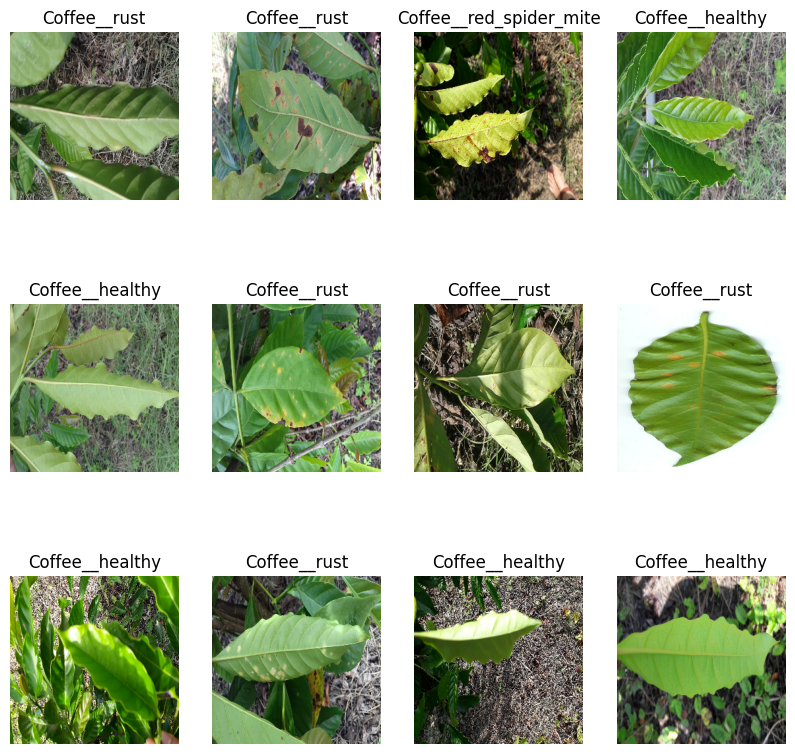

In [17]:
plt.figure(figsize=(10,10)) # Let the whole figure behind be a little big
for image_batch, label_batch in dataset.take(1):
    # Check the first image_batch and label_batch
    # print(image_batch) # image_batch is a tf.Tensor.
    # print(label_batch) # integer labels of images in this batch,
                         # as default of tf.keras.preprocessing.image_dataset_from_directory

    # print(image_batch[0]) # image_batch[0] is a tf.Tensor.

    # # Visualize an image
    # plt.imshow(image_batch[0].numpy().astype("uint8"))
    # plt.axis("off")

    # Visualize several images at a time
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [18]:
len(dataset)

35

### How do we split our dataset?
- 80% ==> training
- 20% ==> 10% validation + 10% test
- The 10% validation is the part of the dataset that we will run validation on after each and every epoch.
- In scikit-learn, we have the ```sklearn.model_selection.train_test_split``` function to split a dataset into train set and test set. We don't have this kind of function in TensorFlow.

In [19]:
train_size = 0.8 # percentage
len(dataset) * train_size

28.0

In [20]:
train_dataset = dataset.take(28) # similar to arr[:54] in Python lists
len(train_dataset)

28

In [21]:
test_dataset = dataset.skip(28) # similar to arr[54:] in Python lists
len(test_dataset)

7

In [22]:
val_size = 0.1
len(dataset) * val_size

3.5

In [23]:
val_dataset = test_dataset.take(3)
len(val_dataset)

3

In [24]:
test_dataset = test_dataset.skip(3)
len(test_dataset)

4

In [25]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Now we have to create layers for pre-processing.

In [26]:
# Resize and rescale layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [27]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = tf.keras.Sequential([ # https://stackoverflow.com/questions/78624800/what-is-the-difference-between-tf-keras-models-sequential-and-tf-keras-sequent # https://www.tensorflow.org/api_docs/python/tf/keras/Input
    resize_and_rescale,
    data_augmentation,

    # First convolutional block
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # Prevent overfitting

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # Prevent overfitting

    # Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # Prevent overfitting


    # Fully Connected Layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(1, 256, 256, 3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 254, 254, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 252, 252, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 124, 124, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 122, 122, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 59, 59, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 57, 57, 128)            │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 100352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 4)                      │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,669,796 (197.10 MB)

 Trainable params: 51,669,796 (197.10 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - accuracy: 0.3858 - loss: 1.8343 - val_accuracy: 0.3750 - val_loss: 1.2348
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 476ms/step - accuracy: 0.3992 - loss: 1.1954 - val_accuracy: 0.3646 - val_loss: 1.1669
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.4326 - loss: 1.1779 - val_accuracy: 0.5104 - val_loss: 1.1450
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.3769 - loss: 1.1731 - val_accuracy: 0.4583 - val_loss: 1.0826
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.3938 - loss: 1.1482 - val_accuracy: 0.3542 - val_loss: 1.1329
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - accuracy: 0.3980 - loss: 1.1213 - val_accuracy: 0.4271 - val_loss: 1.1678
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 473ms/step - accuracy: 0.4164 - loss: 1.1514 - val_accuracy: 0.3542 - val_loss: 1.1225
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.4379 - loss: 1.1046 - val_accu

In [32]:
scores = model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7598 - loss: 0.6019


In [33]:
scores

[0.5356049537658691, 0.792792797088623]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 28}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
history.history['accuracy']

[0.40625,
 0.3883928656578064,
 0.4229910671710968,
 0.3995535671710968,
 0.3995535671710968,
 0.4051339328289032,
 0.4029017984867096,
 0.421875,
 0.4386160671710968,
 0.4386160671710968,
 0.4397321343421936,
 0.4631696343421936,
 0.4497767984867096,
 0.4609375,
 0.4921875,
 0.4899553656578064,
 0.4776785671710968,
 0.4988839328289032,
 0.5145089030265808,
 0.5122767686843872,
 0.5111607313156128,
 0.5066964030265808,
 0.4832589328289032,
 0.5323660969734192,
 0.6060267686843872,
 0.6417410969734192,
 0.6618303656578064,
 0.6383928656578064,
 0.6830357313156128,
 0.7098214030265808,
 0.7310267686843872,
 0.7444196343421936,
 0.7410714030265808,
 0.7466517686843872,
 0.7544642686843872,
 0.7600446343421936,
 0.7633928656578064,
 0.7566964030265808,
 0.7611607313156128,
 0.7879464030265808,
 0.7678571343421936,
 0.7890625,
 0.7935267686843872,
 0.7767857313156128,
 0.7767857313156128,
 0.7868303656578064,
 0.7712053656578064,
 0.7901785969734192,
 0.8035714030265808,
 0.7957589030265808

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

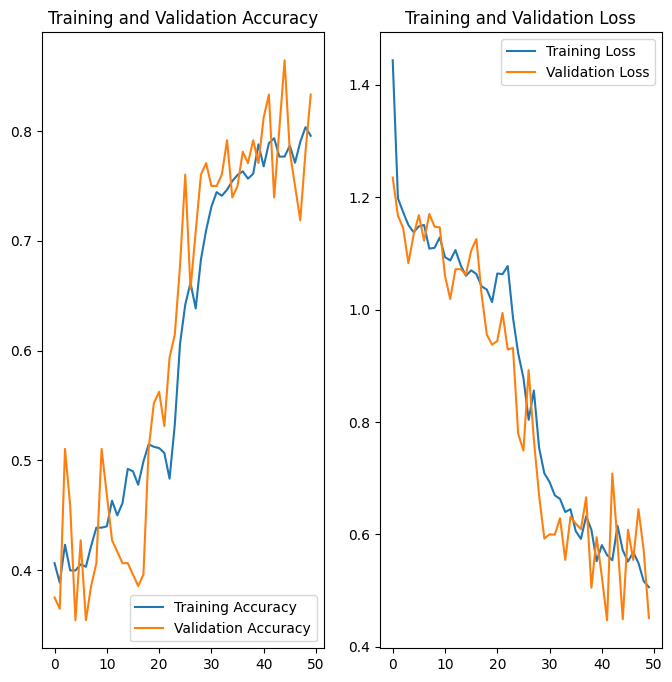

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
def save_model(model):
  # Save the entire model in the native Keras format
  model.save(f'{project_path}/model_v_1_0.keras')

  # Convert to TensorFlow Lite
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_model = converter.convert()
  with open(f'{project_path}/model_v_1_0.tflite', 'wb') as f:
    f.write(tflite_model)

# Save the class names (labels) to a .txt file
def save_labels_to_txt(labels, txt_filename):
    with open(txt_filename, 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

save_model(model)

Saved artifact at '/tmp/tmpa8h448r1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name='keras_tensor_531')
Output Type:
  TensorSpec(shape=(1, 4), dtype=tf.float32, name=None)
Captures:
  134280408866432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408868720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408867664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408870304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408868016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408872416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408871360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408874000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408871712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408873120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134280408869424:

In [49]:
save_labels_to_txt(class_names, f'{project_path}/labels.txt')

In [50]:
# Load saved model
saved_model = tf.keras.models.load_model(f'{project_path}/model_v_1_0.keras')

In [51]:
print(type(saved_model.summary()))
saved_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 254, 254, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 252, 252, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 124, 124, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 122, 122, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 59, 59, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 57, 57, 128)            │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 100352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 4)                      │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,009,390 (591.31 MB)

 Trainable params: 51,669,796 (197.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,339,594 (394.21 MB)

<class 'NoneType'>


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 256, 256, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 254, 254, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 252, 252, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 124, 124, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 122, 122, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 61, 61, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 59, 59, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 57, 57, 128)            │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 28, 28, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 100352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 4)                      │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,009,390 (591.31 MB)

 Trainable params: 51,669,796 (197.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,339,594 (394.21 MB)

first image to predict
first image's actual label:  Coffee__healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Coffee__healthy


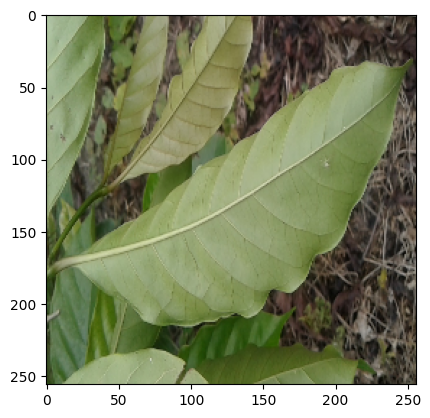

In [44]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

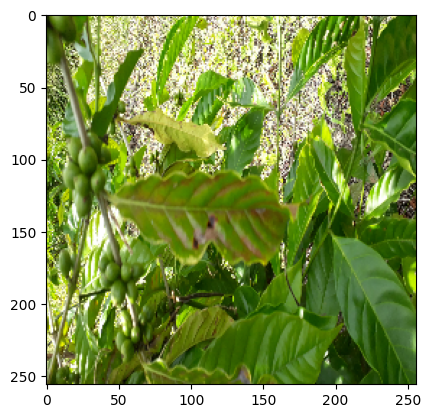

In [46]:
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.imshow(images[i].numpy().astype("uint8"))